## This script is the start of trying to determine how identify which issued bonds (rows) are most similar

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

In [121]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [122]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [123]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import scipy.linalg as scl
from sklearn.preprocessing import MinMaxScaler

## Load data

In [124]:
bonds = pd.read_csv('bond_similarity.csv', parse_dates=['Maturity'])
print(bonds.shape)
bonds.head()

(1211, 39)


,Cusip,ISIN,Description,Ticker,Coupon,Maturity,Composite Rating,Currency,Country,Sector Level 1,...,Prior Month-End Effective Duration,Prior Month-End Effective Yield,Prior Month-End OAS vs Govt,TRR % MTD LOC,Excess Rtn % MTD,Asset Swap Spread,Prior Month-End Asset Swap Spread,OAS vs Swap,Prior Month-End OAS vs Swap,Illiquidity Premium
0,'AL319313',XS1529687870,AA Bond Co Limited,AABOND,2.875,2022-01-31,BBB3,GBP,GB,Securitized/Collateralized,...,3.266,4.221,331.0,0.184,0.068,235.0,285.0,243.0,294.0,NaN
1,'AO236287',XS1645315620,AA Bond Co Limited,AABOND,2.750,2023-07-31,BBB3,GBP,GB,Securitized/Collateralized,...,4.604,4.204,318.0,0.207,0.071,267.0,267.0,282.0,282.0,NaN
2,'AT538379',XS1856940462,AA Bond Co Limited,AABOND,4.875,2024-07-31,BBB3,GBP,GB,Securitized/Collateralized,...,5.168,4.688,360.0,0.193,0.042,323.0,323.0,327.0,327.0,NaN
3,'EJ733791',XS0949169923,AA Bond Co Limited,AABOND,6.269,2025-07-31,BBB3,GBP,GB,Securitized/Collateralized,...,5.728,4.705,354.0,0.273,0.107,433.0,335.0,418.0,324.0,NaN
4,'EJ944681',XS0996575378,AA Bond Co Limited,AABOND,4.249,2020-07-31,BBB3,GBP,GB,Securitized/Collateralized,...,1.892,3.549,278.0,0.284,0.202,137.0,244.0,136.0,243.0,NaN


In [125]:
bonds.columns

Index(['Cusip', 'ISIN', 'Description', 'Ticker', 'Coupon', 'Maturity',
       'Composite Rating', 'Currency', 'Country', 'Sector Level 1',
       'Sector Level 2', 'Sector Level 3', 'Sector Level 4', 'Type',
       'Face Value', 'Price', 'Accrued Interest', '% Weight', 'Cash',
       'Duration To Worst', 'Yield to Worst', 'Effective Duration',
       'Effective Yield', 'OAS vs Govt', 'Prior Month-End Price',
       'Prior Month-End Accrued Interest', 'Prior Month-End % Weight',
       'Prior Month-End Duration To Worst', 'Prior Month-End Yield To Worst',
       'Prior Month-End Effective Duration', 'Prior Month-End Effective Yield',
       'Prior Month-End OAS vs Govt', 'TRR % MTD LOC', 'Excess Rtn % MTD',
       'Asset Swap Spread', 'Prior Month-End Asset Swap Spread',
       'OAS vs Swap ', 'Prior Month-End OAS vs Swap', 'Illiquidity Premium'],
      dtype='object')

In [126]:
numeric_columns = bonds.describe().columns.tolist()
numeric_columns.remove('Illiquidity Premium')
numeric_columns.append('Maturity In Years')
non_numeric_columns = [col for col in bonds.columns if (col not in numeric_columns) & (col not in ['Maturity', 'Illiquidity Premium'])]

In [127]:
bonds = bonds.loc[bonds['Type']!='CASH'].reset_index(drop=True).copy()

In [128]:
non_numeric_columns

['Cusip',
 'ISIN',
 'Description',
 'Ticker',
 'Composite Rating',
 'Currency',
 'Country',
 'Sector Level 1',
 'Sector Level 2',
 'Sector Level 3',
 'Sector Level 4',
 'Type']

In [129]:
rating_dict = {'AAA':10, 'AA1':20, 'AA2':30, 'AA3':40, 'A1':50, 'A2':60, 'A3':70,
              'BBB1':80, 'BBB2':90, 'BBB3':100}

In [130]:
bonds['Numeric Rating'] = bonds['Composite Rating'].map(rating_dict)

# Explore Data

In [131]:
pd.crosstab(bonds['Composite Rating'], bonds['Type'], margins=True)

Type,JSUB,SECR,SENR,SSEN,SSUB,SUB,T1,T2,UT2,All
Composite Rating,,,,,,,,,,
A1,0,14,62,6,1,0,0,0,0,83
A2,0,16,80,23,0,3,0,1,0,123
A3,2,32,74,31,2,5,0,13,0,159
AA1,0,3,16,2,0,0,0,0,0,21
AA2,0,11,29,14,1,0,0,0,0,55
AA3,0,6,77,7,0,0,0,0,0,90
AAA,0,28,125,5,0,0,0,0,0,158
BBB1,6,5,160,31,0,23,0,11,0,236
BBB2,4,4,92,21,3,7,1,12,0,144


In [132]:
pd.crosstab(bonds['Sector Level 2'], bonds['Type'], margins=True)

Type,JSUB,SECR,SENR,SSEN,SSUB,SUB,T1,T2,UT2,All
Sector Level 2,,,,,,,,,,
Covered,0,31,1,0,0,0,0,0,0,32
Financial,12,10,148,0,0,40,9,43,1,263
Industrials,3,57,317,13,0,2,0,0,0,392
Quasi & Foreign Government,0,10,167,0,0,0,0,0,0,177
Securitized,0,8,0,139,8,0,0,0,0,155
Utility,7,8,112,0,0,1,0,0,0,128
All,22,124,745,152,8,43,9,43,1,1147


In [133]:
bonds.isnull().sum().sort_values(ascending=False).head(20)

Illiquidity Premium                  1149
Duration To Worst                      63
Prior Month-End Price                  63
Sector Level 1                         63
Sector Level 2                         63
Sector Level 3                         63
Sector Level 4                         63
Type                                   63
Face Value                             63
Ticker                                 63
Accrued Interest                       63
% Weight                               63
Cash                                   63
Yield to Worst                         63
Effective Yield                        63
OAS vs Govt                            63
Prior Month-End Accrued Interest       63
Prior Month-End % Weight               63
Prior Month-End Duration To Worst      63
Prior Month-End Yield To Worst         63
dtype: int64

In [134]:
bonds[~bonds['Prior Month-End Yield To Worst'].isnull()].isnull().sum().sort_values(ascending=False).head()

Illiquidity Premium    1147
Numeric Rating            0
% Weight                  0
Accrued Interest          0
Price                     0
dtype: int64

In [135]:
bonds_clean = bonds[~bonds['Prior Month-End Yield To Worst'].isnull()].copy()
bonds_clean = bonds_clean.drop('Illiquidity Premium', axis=1)

In [136]:
bonds_clean['Sector Level 2'].value_counts()

Industrials                   392
Financial                     263
Quasi & Foreign Government    177
Securitized                   155
Utility                       128
Covered                        32
Name: Sector Level 2, dtype: int64

In [137]:
bonds_clean['Country'].value_counts().head()

GB    617
US    117
DE     92
FR     61
XB     54
Name: Country, dtype: int64

In [138]:
# pd.crosstab(bonds['Country'], bonds['Composite Rating'], margins=True)

In [139]:
bonds_clean['Maturity In Years'] = (bonds_clean['Maturity'] - pd.Timestamp.today()) / np.timedelta64(1, 'Y')

## Numerical feature selection
* there are many correlated numerical features
* let us select the most important ones

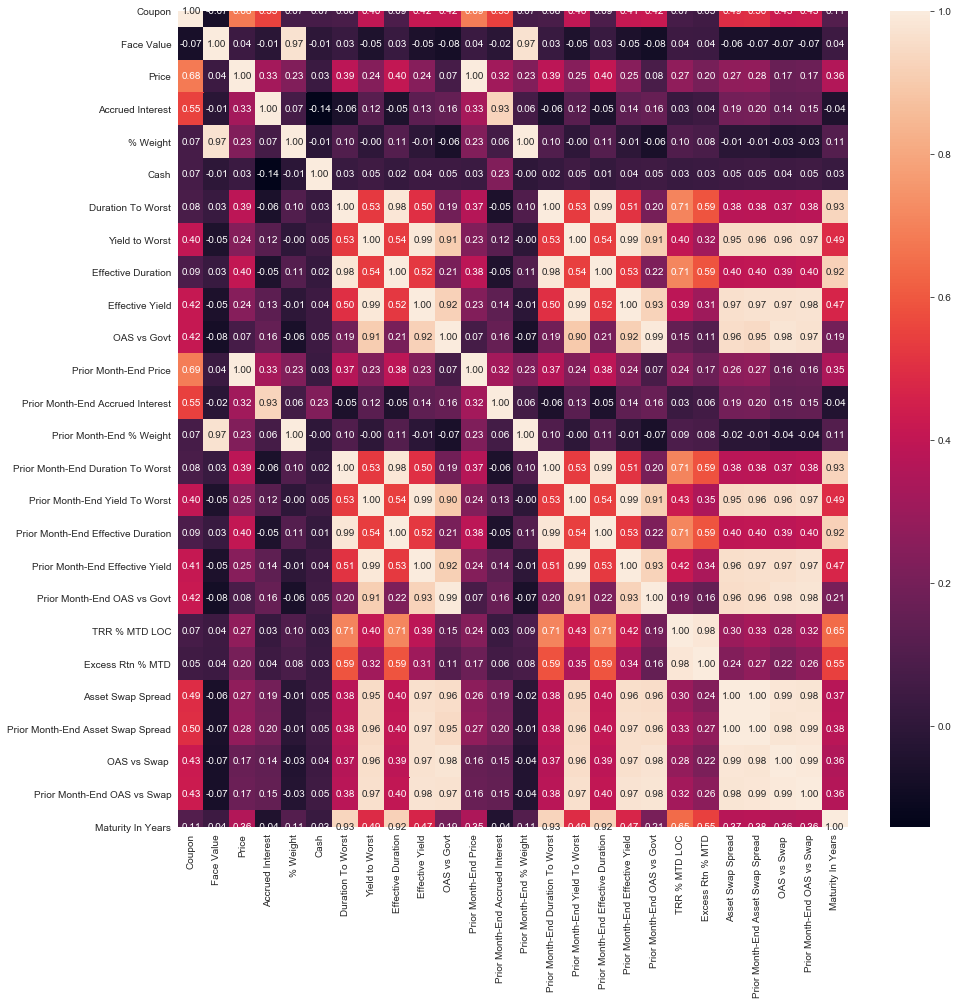

In [140]:
fig, ax0 = plt.subplots(1,1,figsize=(15,15))
sns.heatmap(bonds_clean[numeric_columns].corr(), annot=True, fmt=".2f", ax=ax0)

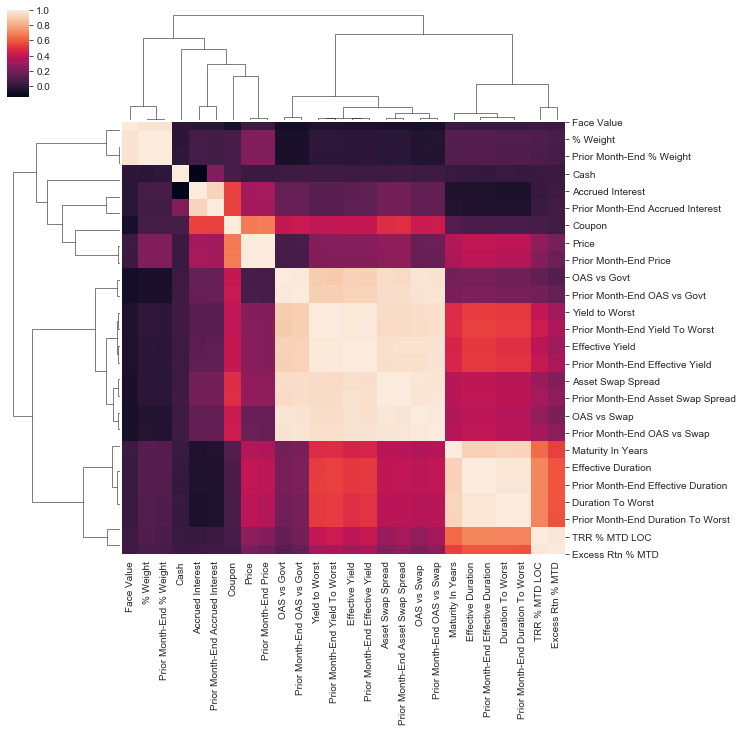

In [141]:
sns.clustermap(bonds_clean[numeric_columns].corr())

In [142]:
d = sch.distance.pdist(bonds_clean[numeric_columns].corr())
L = sch.linkage(d, method='complete')
# 0.2 can be modified to retrieve more stringent or relaxed clusters
clusters_corr = sch.fcluster(L, 0.5, 'distance')

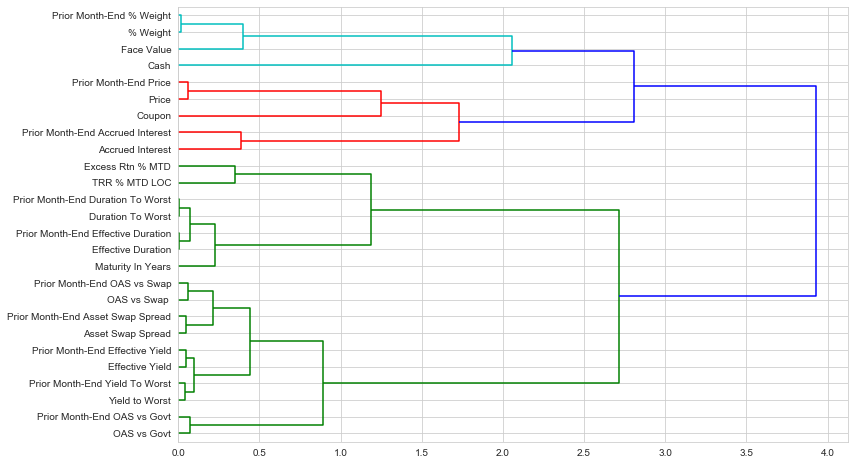

In [143]:
fig, ax0 = plt.subplots(1, 1, figsize=(12, 8))
dn =  sch.dendrogram(L, ax=ax0, labels=numeric_columns, orientation='right')

In [144]:
numeric_features_clusters = pd.Series(clusters_corr, index=numeric_columns).sort_values()

In [145]:
numeric_features_clusters[numeric_features_clusters==8]

% Weight                    8
Face Value                  8
Prior Month-End % Weight    8
dtype: int32

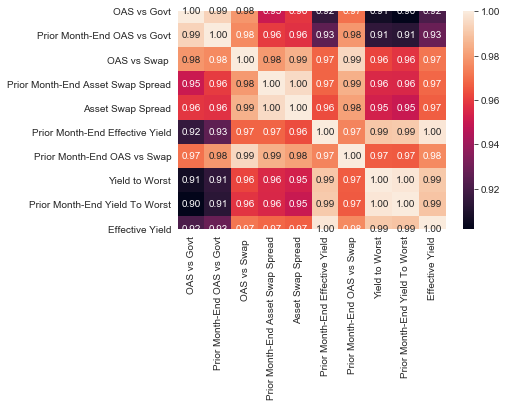

In [146]:
sns.heatmap(bonds_clean[numeric_features_clusters[numeric_features_clusters<=2].index].corr(), annot=True, fmt=".2f")

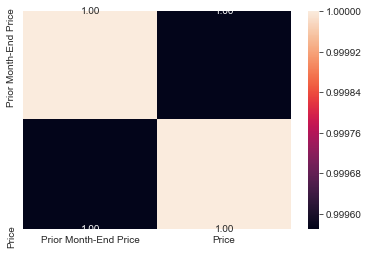

In [147]:
sns.heatmap(bonds_clean[numeric_features_clusters[numeric_features_clusters==6].index].corr(), annot=True, fmt=".2f")

* Let us choose single variable from each cluster
    1. OAS vs Govt
    2. Yiled to Worst
    3. Duration to Worst
    4. TRR % MTD LOC
    5. Price
    6. Coupon
* Choose to ignore:
    1. Accrued Interest
    2. Face value / weight

In [148]:
good_numerical_columns = ['OAS vs Govt', 'Yield to Worst', 'Duration To Worst', 'TRR % MTD LOC', 'Price', 'Coupon', 'Numeric Rating']

C:\Users\Visi\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Visi\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


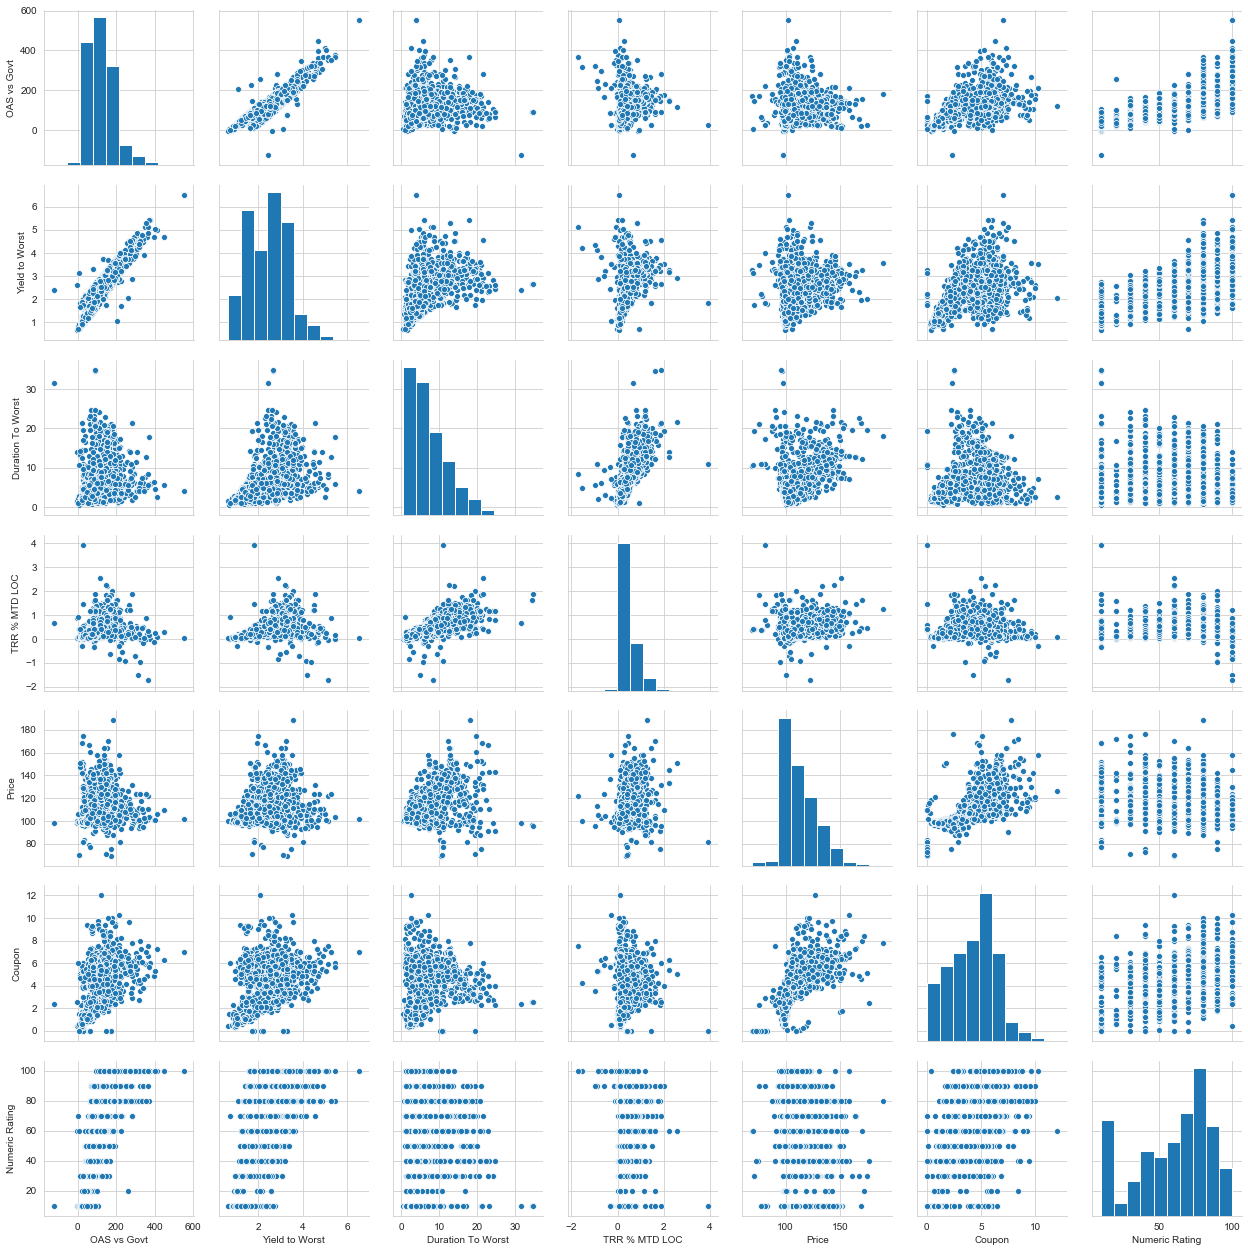

In [149]:
sns.pairplot(bonds[good_numerical_columns])

In [151]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    https://www.machinelearningplus.com/statistics/mahalanobis-distance/
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = scl.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [152]:
bonds_clean['mahala'] = mahalanobis(x=bonds_clean[['OAS vs Govt', 'Yield to Worst']],
                                    data=bonds_clean[['OAS vs Govt', 'Yield to Worst']])

In [153]:
bonds_clean['mahala_all'] = mahalanobis(x=bonds_clean[good_numerical_columns],
                                    data=bonds_clean[good_numerical_columns])

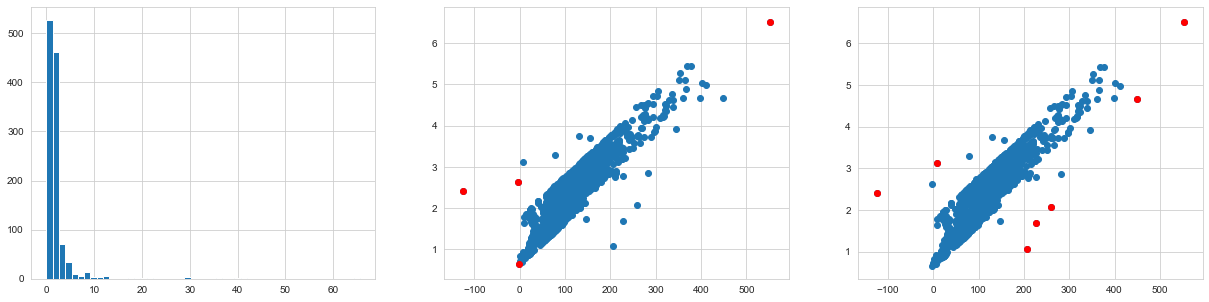

In [154]:

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(21,5))
bonds_clean['mahala'].hist(bins=50, ax=ax0)
ax1.scatter(bonds_clean['OAS vs Govt'], bonds_clean['Yield to Worst'])
ax1.scatter(bonds_clean.loc[(bonds_clean['OAS vs Govt']<0) | (bonds_clean['OAS vs Govt']>500)| (bonds_clean['Yield to Worst']>6), 'OAS vs Govt'], 
            bonds_clean.loc[(bonds_clean['OAS vs Govt']<0) | (bonds_clean['OAS vs Govt']>500) | (bonds_clean['Yield to Worst']>6), 'Yield to Worst'], c='r')
ax2.scatter(bonds_clean['OAS vs Govt'], bonds_clean['Yield to Worst'])
mahala_limit = 25
ax2.scatter(bonds_clean.loc[bonds_clean['mahala']>mahala_limit, 'OAS vs Govt'], bonds_clean.loc[bonds_clean['mahala']>mahala_limit, 'Yield to Worst'], c='r')
# ax2.scatter(bonds_clean.loc[bonds_clean['mahala_all']>mahala_limit, 'OAS vs Govt'], bonds_clean.loc[bonds_clean['mahala_all']>mahala_limit, 'Yield to Worst'], c='r')


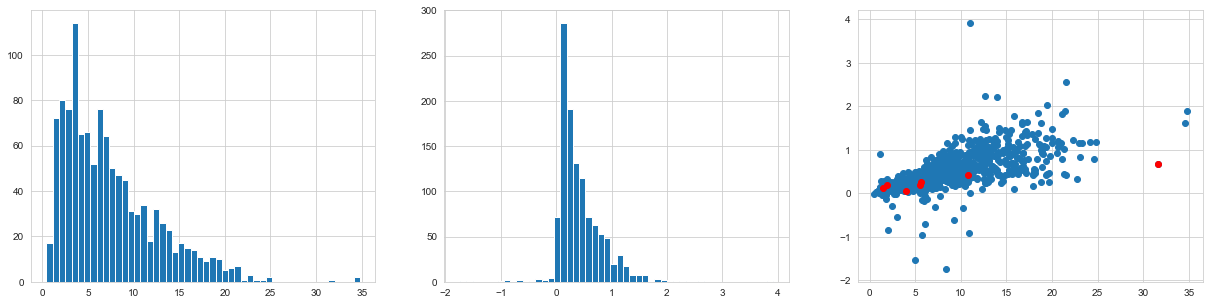

In [155]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(21,5))
bonds_clean['Duration To Worst'].hist(bins=50, ax=ax0)
bonds_clean['TRR % MTD LOC'].hist(bins=50, ax=ax1)
ax2.scatter(bonds_clean['Duration To Worst'], bonds_clean['TRR % MTD LOC'])
ax2.scatter(bonds_clean.loc[bonds_clean['mahala']>25, 'Duration To Worst'], bonds_clean.loc[bonds_clean['mahala']>25, 'TRR % MTD LOC'], c='r')

## Outliers
1. Reject based on single parameter 
2. Reject based on mahal
3. Use bins instead of absolute values

In [156]:
outliers = (bonds_clean['mahala']>25)
sum(outliers)

7

In [157]:
bonds_clean = bonds_clean[~outliers].reset_index(drop=True).copy()

# More about numerical similarities
* Euclidean distance is better than cosine similarity because (1,1) and (100,100) are similar but not close and we need close

In [158]:
# bonds_clean[good_numerical_columns]
good_numerical_columns

['OAS vs Govt',
 'Yield to Worst',
 'Duration To Worst',
 'TRR % MTD LOC',
 'Price',
 'Coupon',
 'Numeric Rating']

In [159]:
numerical_similarity = pd.DataFrame(1 / (1 + euclidean_distances(bonds_clean[good_numerical_columns])), index=bonds_clean.index)
numerical_similarity = numerical_similarity - np.eye(len(numerical_similarity))

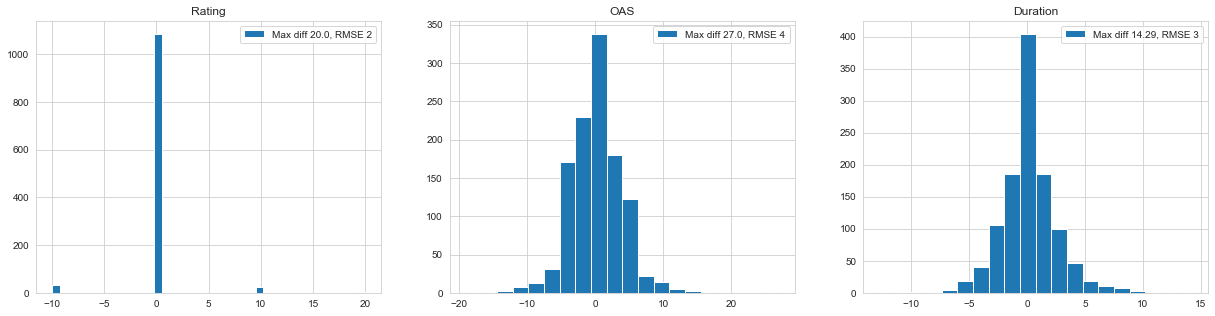

In [160]:
rating_diff = pd.Series(data=0, index=bonds_clean.index)
oas_diff = pd.Series(data=0, index=bonds_clean.index)
duration_diff = pd.Series(data=0, index=bonds_clean.index)

most_similar_bond = numerical_similarity.idxmax(axis=1)

for idx, row in bonds_clean.iterrows():
    idx_similar = most_similar_bond.loc[idx]
    rating_diff.loc[idx] = bonds_clean.loc[idx, 'Numeric Rating'] - bonds_clean.loc[idx_similar, 'Numeric Rating']
    oas_diff.loc[idx] = bonds_clean.loc[idx, 'OAS vs Govt'] - bonds_clean.loc[idx_similar, 'OAS vs Govt']
    duration_diff.loc[idx] = bonds_clean.loc[idx, 'Duration To Worst'] - bonds_clean.loc[idx_similar, 'Duration To Worst']
        
fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(21,5))
rating_diff.hist(bins=40, ax=ax0)
oas_diff.hist(bins=20, ax=ax1)
duration_diff.hist(bins=20, ax=ax2)
ax0.legend(['Max diff {0}, RMSE {1:.0f}'.format(rating_diff.abs().max(), np.sqrt((rating_diff**2).mean()))])
ax1.legend(['Max diff {0}, RMSE {1:.0f}'.format(oas_diff.abs().max(), np.sqrt((oas_diff**2).mean()))])
ax2.legend(['Max diff {0:.2f}, RMSE {1:.0f}'.format(duration_diff.abs().max(), np.sqrt((duration_diff**2).mean()))])
ax0.set(Title='Rating')
ax1.set(Title='OAS')
ax2.set(Title='Duration');